In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [2]:
# load austin radar data for validation
link_to_radar_data = 'data for validation/Austin/traffic count/Austin data/'
radar_data_file = 'Radar_Traffic_Counts.csv'
austin_radar_data = read_csv(link_to_radar_data + radar_data_file, sep = ',')
austin_radar_data.head(5)

,Row ID,Detector ID,KITS ID,Read Date,Intersection Name,Lane,Volume,Occupancy,Speed,Month,Day,Year,Hour,Minute,Day of Week,Time Bin,Direction
0,17e8c8848df83e21cee36315871b980f,43,14,01/24/2018 05:45:00 AM +0000,Robert E LeeBarton Springs,NB,1,0,24,1,23,2018,23,45,2,23:45,NB
1,164e01024e79a63514de5ac92aff6512,56,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_out,26,1,53,1,23,2018,23,45,2,23:45,SB
2,b380b3e3567c60400bb045b6b9c6ad54,57,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_mid,20,0,51,1,23,2018,23,45,2,23:45,SB
3,65ce074d6ad79b8e2aa04ff1b87f0ba0,58,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_in,4,0,59,1,23,2018,23,45,2,23:45,SB
4,9d28753433afb44179d99c3e5032c069,59,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_Lturn,1,0,22,1,23,2018,23,45,2,23:45,SB


In [3]:
# post-process radar data and assign attributes
austin_radar_data.loc[:, 'datetime'] = austin_radar_data.loc[:,'Read Date'].str[:-6]
austin_radar_data.loc[:,'date_dt'] = pd.to_datetime(austin_radar_data.loc[:,'datetime'], format='%m/%d/%Y  %I:%M:%S %p', errors = 'coerce')
austin_radar_data = austin_radar_data.loc[austin_radar_data['date_dt'] != 'NaT']
austin_radar_data.loc[:,'date_formatted'] = austin_radar_data.loc[:,'date_dt'].dt.date
austin_radar_data.loc[:,'hour_formatted'] = austin_radar_data.loc[:,'date_dt'].dt.hour
austin_radar_data = austin_radar_data.loc[austin_radar_data['KITS ID'] != 18]
austin_radar_data["Year"] = austin_radar_data["Year"].astype(int)
austin_radar_data.head(5)

,Row ID,Detector ID,KITS ID,Read Date,Intersection Name,Lane,Volume,Occupancy,Speed,Month,...,Year,Hour,Minute,Day of Week,Time Bin,Direction,datetime,date_dt,date_formatted,hour_formatted
0,17e8c8848df83e21cee36315871b980f,43,14,01/24/2018 05:45:00 AM +0000,Robert E LeeBarton Springs,NB,1,0,24,1,...,2018,23,45,2,23:45,NB,01/24/2018 05:45:00 AM,2018-01-24 05:45:00,2018-01-24,5.0
1,164e01024e79a63514de5ac92aff6512,56,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_out,26,1,53,1,...,2018,23,45,2,23:45,SB,01/24/2018 05:45:00 AM,2018-01-24 05:45:00,2018-01-24,5.0
2,b380b3e3567c60400bb045b6b9c6ad54,57,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_mid,20,0,51,1,...,2018,23,45,2,23:45,SB,01/24/2018 05:45:00 AM,2018-01-24 05:45:00,2018-01-24,5.0
3,65ce074d6ad79b8e2aa04ff1b87f0ba0,58,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_in,4,0,59,1,...,2018,23,45,2,23:45,SB,01/24/2018 05:45:00 AM,2018-01-24 05:45:00,2018-01-24,5.0
4,9d28753433afb44179d99c3e5032c069,59,8,01/24/2018 05:45:00 AM +0000,LOOP 360WALSH TARLTON,SB_Lturn,1,0,22,1,...,2018,23,45,2,23:45,SB,01/24/2018 05:45:00 AM,2018-01-24 05:45:00,2018-01-24,5.0


In [4]:
# select observed data for validation
austin_radar_data_validation = austin_radar_data.loc[austin_radar_data["Year"] == 2018]
austin_radar_data_validation = austin_radar_data_validation.loc[austin_radar_data_validation["Day of Week"]<=5]
austin_radar_data_validation.loc[austin_radar_data_validation['Speed']>= 80, 'Speed'] = 80
austin_radar_data_validation.loc[:, 'Volume'] *= 4 # convert 15-min volume to hourly
austin_radar_data_hourly_volume = austin_radar_data_validation.groupby(['KITS ID', 'Hour'])[['Volume']].mean()
austin_radar_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
austin_radar_data_hourly_volume = austin_radar_data_hourly_volume.reset_index()
austin_radar_data_hourly_speed = austin_radar_data_validation.groupby(['KITS ID', 'Hour']).apply(lambda x: np.average(x.Speed, weights=x.Volume))
austin_radar_data_hourly_speed = austin_radar_data_hourly_speed.reset_index()
austin_radar_data_hourly_speed.columns = ['KITS ID', 'Hour', 'Avg.Speed (mph)']

austin_radar_data_hourly_data = pd.merge(austin_radar_data_hourly_volume,
                                         austin_radar_data_hourly_speed,
                                         on = ['KITS ID', 'Hour'], how = 'left')
austin_radar_data_hourly_data.head(5)

,KITS ID,Hour,Volume (veh/lane/hour),Avg.Speed (mph)
0,1,0,84.254601,34.058179
1,1,1,48.372951,34.404050
2,1,2,35.384536,34.948606
3,1,3,21.061792,34.515329
4,1,4,15.496032,35.123560


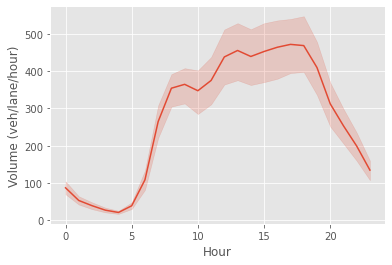

In [5]:
sns.lineplot(data = austin_radar_data_hourly_data, x = "Hour", y = "Volume (veh/lane/hour)", ci=95)
# plt.ylim([0, 70])
# plt.ylabel('average speed (mph)')
plt.savefig('plot/austin_observed_hourly_mean_volume.png', bbox_inches='tight', dpi = 300)
plt.show()

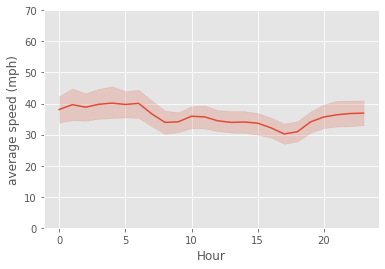

In [6]:
sns.lineplot(data = austin_radar_data_hourly_data, x = "Hour", y = "Avg.Speed (mph)", ci=95)
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt.savefig('plot/austin_observed_hourly_mean_speed.png', bbox_inches='tight', dpi = 300)
plt.show()

In [7]:
# load BEAM output
modeled_vmt = read_csv('sample output/AUS2010/0.linkstats.csv.gz', low_memory=False)
model_network = read_csv('sample output/AUS2010/BEAM_network_screenlines.csv', low_memory=False)

In [8]:
meter_to_mile = 0.000621371
percent_of_samples = 0.2
mps_to_mph = 2.23694
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)

,Unnamed: 0,linkId,linkLength,length,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,KITS_ID
0,11145,172956,12.407,12.415162,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,14,453,5
1,11146,172957,12.407,12.415162,24.5872,4600,2.0,walk;bike,51864152,primary,27400,80933,Travis,14,453,5
2,11147,172958,53.300,52.578029,24.5872,4600,2.0,car;walk;bike,51864153,primary,41825,80933,Travis,14,453,5
3,11148,172959,53.300,52.578029,24.5872,4600,2.0,walk;bike,51864153,primary,80933,41825,Travis,14,453,5
4,15153,192552,113.051,112.225834,24.5872,2300,1.0,car;walk;bike,143948147,primary,87049,89167,Travis,14,453,5


In [9]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,link,from,to,hour,length_x,freespeed,capacity,stat,volume,traveltime,...,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,KITS_ID
0,206320,90670,94066,5.0,94.099,13.4112,2100.0,AVG,33.0,7.071870,...,1.0,car;walk;bike,177702412,tertiary,90670,94066,Travis,14,453,8
1,206320,90670,94066,6.0,94.099,13.4112,2100.0,AVG,57.0,7.130358,...,1.0,car;walk;bike,177702412,tertiary,90670,94066,Travis,14,453,8
2,206320,90670,94066,7.0,94.099,13.4112,2100.0,AVG,62.0,7.385551,...,1.0,car;walk;bike,177702412,tertiary,90670,94066,Travis,14,453,8
3,206320,90670,94066,8.0,94.099,13.4112,2100.0,AVG,85.0,7.391131,...,1.0,car;walk;bike,177702412,tertiary,90670,94066,Travis,14,453,8
4,206320,90670,94066,9.0,94.099,13.4112,2100.0,AVG,78.0,7.920375,...,1.0,car;walk;bike,177702412,tertiary,90670,94066,Travis,14,453,8


In [10]:
model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw', 
                                                        'length_y': 'length_adj'})
print(model_vmt_24_hour.columns)

Index(['link', 'from', 'to', 'hour', 'length_raw', 'freespeed', 'capacity',
       'stat', 'volume', 'traveltime', 'Unnamed: 0', 'linkId', 'linkLength',
       'length_adj', 'linkFreeSpeed', 'linkCapacity', 'numberOfLanes',
       'linkModes', 'attributeOrigId', 'attributeOrigType', 'fromNodeId',
       'toNodeId', 'name', 'txdot_abbr', 'fips_code', 'KITS_ID'],
      dtype='object')


In [11]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']


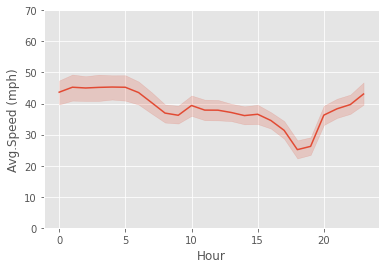

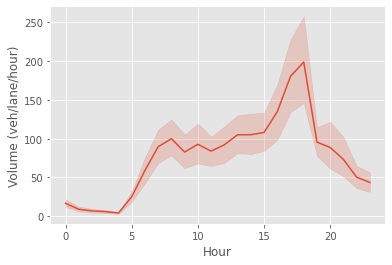

In [12]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['KITS_ID', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['KITS ID', 'Hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['KITS_ID', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['KITS ID', 'Hour', 'Avg.Speed (mph)'] 
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['KITS ID', 'Hour'], how = 'left')
sns.lineplot(x = 'Hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/modeled_speed_screenline.png', dpi = 200)
plt.show()

sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/modeled_volume_screenline.png', dpi = 200)
plt.show()

In [13]:
# compare two datasets
austin_radar_data_hourly_data.loc[:, 'source'] = 'Austin radar data'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([austin_radar_data_hourly_data, model_vmt_hour_data])
combined_data = combined_data.reset_index()
combined_data.head(5)

,index,KITS ID,Hour,Volume (veh/lane/hour),Avg.Speed (mph),source
0,0,1,0.0,84.254601,34.058179,Austin radar data
1,1,1,1.0,48.372951,34.404050,Austin radar data
2,2,1,2.0,35.384536,34.948606,Austin radar data
3,3,1,3.0,21.061792,34.515329,Austin radar data
4,4,1,4.0,15.496032,35.123560,Austin radar data


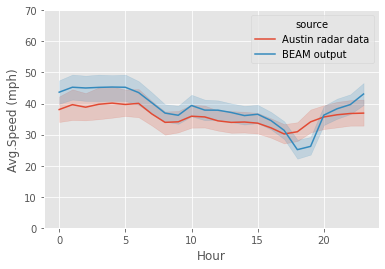

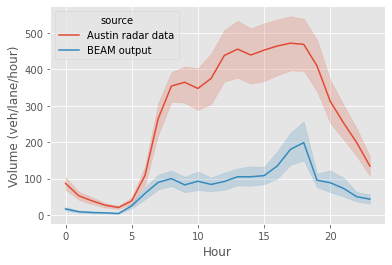

In [14]:
sns.lineplot(x = 'Hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/BEAM_screenline_speed_validation.png', dpi = 200)
plt.show()

sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/BEAM_screenline_volume_validation.png', dpi = 200)
plt.show()

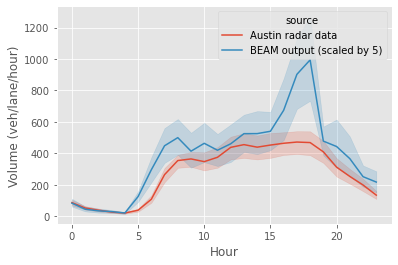

In [15]:
model_vmt_hour_data_scaled = model_vmt_hour_data.copy()
model_vmt_hour_data_scaled.loc[:, 'Volume (veh/lane/hour)'] *= 5
model_vmt_hour_data_scaled.loc[:, 'source'] = 'BEAM output (scaled by 5)'
#model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data_scaled = pd.concat([austin_radar_data_hourly_data, model_vmt_hour_data_scaled])
combined_data_scaled = combined_data_scaled.reset_index()
combined_data_scaled.head(5)
sns.lineplot(x = 'Hour', y = 'Volume (veh/lane/hour)', hue = 'source', 
             data = combined_data_scaled, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/BEAM_screenline_scaled_volume_validation.png', dpi = 200)
plt.show()

In [16]:
paired_data_for_comparison = pd.merge(austin_radar_data_hourly_data, model_vmt_hour_data,
                                      on = ['KITS ID', 'Hour'], how = 'left')
paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'Austin radar speed',
                                                                         'Avg.Speed (mph)_y': 'BEAM speed',
                                                                         'Volume (veh/lane/hour)_x': 'Austin radar volume',
                                                                         'Volume (veh/lane/hour)_y': 'BEAM volume'})
paired_data_for_comparison["KITS ID"] = paired_data_for_comparison["KITS ID"].astype(str)
paired_data_for_comparison.head(5)

,KITS ID,Hour,Austin radar volume,Austin radar speed,source_x,BEAM volume,BEAM speed,source_y
0,1,0,84.254601,34.058179,Austin radar data,18.3125,43.520399,BEAM output
1,1,1,48.372951,34.404050,Austin radar data,6.0000,45.837359,BEAM output
2,1,2,35.384536,34.948606,Austin radar data,7.6250,45.745974,BEAM output
3,1,3,21.061792,34.515329,Austin radar data,5.6250,46.793121,BEAM output
4,1,4,15.496032,35.123560,Austin radar data,4.3750,48.505266,BEAM output


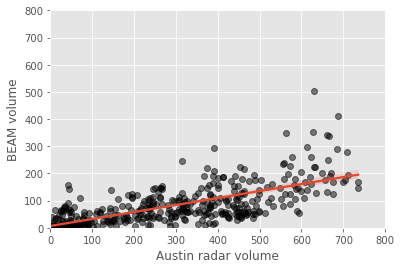

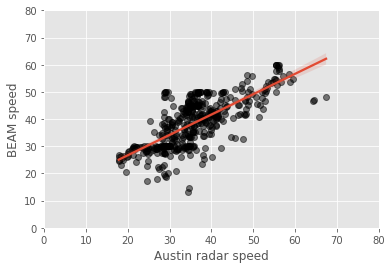

In [17]:
sns.regplot(data=paired_data_for_comparison, x="Austin radar volume", y="BEAM volume",
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 800])
plt.ylim([0, 800])
plt.savefig('plot/paired_screenline_volume_validation.png', dpi = 200)
plt.show()
sns.regplot(data=paired_data_for_comparison, x="Austin radar speed", y="BEAM speed",
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.savefig('plot/paired_screenline_speed_validation.png', dpi = 200)
plt.show()

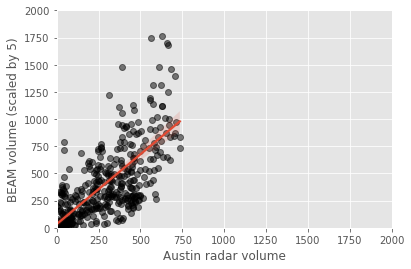

In [18]:
paired_data_for_comparison.loc[:, 'BEAM volume (scaled by 5)'] = paired_data_for_comparison.loc[:, 'BEAM volume'] * 5
sns.regplot(data=paired_data_for_comparison, x="Austin radar volume", y='BEAM volume (scaled by 5)',
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 2000])
plt.ylim([0, 2000])
plt.savefig('plot/paired_screenline_scaled_volume_validation.png', dpi = 200)
plt.show()

In [24]:
model_network_with_observed_traffic = pd.merge(model_network, austin_radar_data_hourly_data, 
                                               left_on = 'KITS_ID', right_on = 'KITS ID', how = 'left')
model_network_with_observed_traffic.loc[:, 'Volume(veh/hour)'] = model_network_with_observed_traffic.loc[:, 'Volume (veh/lane/hour)'] * \
model_network_with_observed_traffic.loc[:, 'numberOfLanes']
list_of_out_var = ['linkId', 'linkLength', 'linkFreeSpeed', 'linkCapacity', 
                   'numberOfLanes', 'linkModes', 'attributeOrigId',
                   'attributeOrigType', 'fromNodeId', 'toNodeId', 'name',
                   'Hour', 'Avg.Speed (mph)', 'Volume(veh/hour)', 'source']
model_network_with_observed_traffic = model_network_with_observed_traffic.loc[:, list_of_out_var]
model_network_with_observed_traffic.to_csv('sample output/AUS2010/observed_data_for_validation_part_1.csv', index = False)
model_network_with_observed_traffic.head(5)

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,Hour,Avg.Speed (mph),Volume(veh/hour),source
0,172956,12.407,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,0,35.669505,298.383698,Austin radar data
1,172956,12.407,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,1,36.201443,177.524096,Austin radar data
2,172956,12.407,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,2,36.882959,129.848024,Austin radar data
3,172956,12.407,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,3,36.848391,80.326326,Austin radar data
4,172956,12.407,24.5872,4600,2.0,car;walk;bike,51864152,primary,80933,27400,Travis,4,36.833605,53.755102,Austin radar data
